In [9]:
import pickle
import numpy as np

In [10]:
with open('negatives_data_train.pkl', 'rb') as f:
    negatives_data_train = pickle.load(f)
with open('negatives_targets_train.pkl', 'rb') as f:
    negatives_targets_train = pickle.load(f)
with open('positives_data_train.pkl', 'rb') as f:
    positives_data_train = pickle.load(f)
with open('positives_targets_train.pkl', 'rb') as f:
    positives_targets_train = pickle.load(f)
with open('negatives_data_test.pkl', 'rb') as f:
    negatives_data_test = pickle.load(f)
with open('negatives_targets_test.pkl', 'rb') as f:
    negatives_targets_test = pickle.load(f)
with open('positives_data_test.pkl', 'rb') as f:
    positives_data_test = pickle.load(f)
with open('positives_targets_test.pkl', 'rb') as f:
    positives_targets_test = pickle.load(f)
with open('unsup_data.pkl', 'rb') as f:
    unsup_data = pickle.load(f)

In [11]:
data_train = positives_data_train + negatives_data_train
targets_train = positives_targets_train + negatives_targets_train
data_test = positives_data_test + negatives_data_test
targets_test = positives_targets_test + negatives_targets_test
data = data_train + data_test + unsup_data
len(data)

100000

In [171]:
import matplotlib.pyplot as plt

In [161]:
y_train = list(map(lambda x:int(x), targets_train))
y_test = list(map(lambda x:int(x), targets_test))

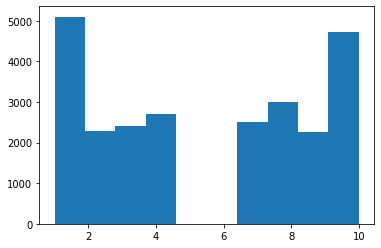

In [176]:
plt.hist(y_train);

# Data preprocessing 

In [12]:
import re
import nltk

In [237]:
def prep(review):
    
    review = re.sub("[^a-zA-Z]", " ", review)
    review = review.lower()
    token = nltk.word_tokenize(review)
    review = [nltk.stem.SnowballStemmer('english').stem(w) for w in token]
    
    return " ".join(review)

In [265]:
prep(data[0])

'bromwel high is a cartoon comedi it ran at the same time as some other program about school life such as teacher my year in the teach profess lead me to believ that bromwel high s satir is much closer to realiti than is teacher the scrambl to surviv financi the insight student who can see right through their pathet teacher pomp the petti of the whole situat all remind me of the school i knew and their student when i saw the episod in which a student repeat tri to burn down the school i immedi recal at high a classic line inspector i m here to sack one of your teacher student welcom to bromwel high i expect that mani adult of my age think that bromwel high is far fetch what a piti that it isn t'

In [10]:
%%time
data_train_prep = list(map(prep, data_train))
data_test_prep = list(map(prep, data_test))
unsup_data_prep = list(map(prep, unsup_data))

Wall time: 11min 7s


In [11]:
# with open('data_train_prep.pkl', 'wb') as f:
#     pickle.dump(data_train_prep, f)
# with open('data_test_prep.pkl', 'wb') as f:
#     pickle.dump(data_test_prep, f)
# with open('unsup_data_prep.pkl', 'wb') as f:
#     pickle.dump(unsup_data_prep, f)

In [14]:
# with open('unsup_data_prep.pkl', 'rb') as f:
#     unsup_data_prep = pickle.load(f)
# with open('data_test_prep.pkl', 'rb') as f:
#     data_test_prep = pickle.load(f)
# with open('data_train_prep.pkl', 'rb') as f:
#     data_train_prep = pickle.load(f)

# Tf-idf

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import words

In [155]:
tv = TfidfVectorizer(
                    ngram_range = (1,3),
                    sublinear_tf = True,
                    max_features = 40000
                    )

In [156]:
%%time
vectors = tv.fit_transform(data_train_prep)

Wall time: 49 s


In [157]:
vectors.shape

(25000, 40000)

In [158]:
%%time
X_train_tv = tv.transform(data_train_prep)
X_test_tv = tv.transform(data_test_prep) 

Wall time: 39.8 s


# Modeling

## LGR

In [162]:
from sklearn.utils import shuffle

In [163]:
X_train_tv, y_train = shuffle(X_train_tv, y_train, random_state=0)

In [164]:
from sklearn.linear_model import LogisticRegression

In [165]:
lgr = LogisticRegression(n_jobs=-1)

In [166]:
%%time
lgr.fit(X_train_tv, y_train)

C:\Users\Timur\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Timur\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Timur\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Wall time: 16.4 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [119]:
def pos_neg(y):
    return list(map(lambda x: 0 if x < 5 else 1, y))

In [128]:
import pandas as pd 
import scikitplot as skplt
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score

In [186]:
def Evaluate(model, X_test, pn=False):

    predicted = model.predict(X_test)
    actual = y_test
    labels = list(set(y_test))
    
    if pn == True :
        predicted = pos_neg(predicted)
        actual = pos_neg(actual)
        labels = list(set(pos_neg(labels)))
    
    output_labels = []
    output = []
    
    # Calculate and display confusion matrix
    cm = confusion_matrix(actual, predicted, labels=labels)
#     print("Confusion matrix\n- x-axis is true labels (none, comp1, etc.)\n- y-axis is predicted labels")
#     print(cm)
    
    # Calculate precision, recall, and F1 score
    accuracy = np.array([float(np.trace(cm)) / np.sum(cm)] * len(labels))
    precision = precision_score(actual, predicted, average=None, labels=labels)
    recall = recall_score(actual, predicted, average=None, labels=labels)
    f1 = 2 * precision * recall / (precision + recall)
    output.extend([accuracy.tolist(), precision.tolist(), recall.tolist(), f1.tolist()])
    output_labels.extend(["accuracy", "precision", "recall", "F1"])

    output_df = pd.DataFrame(output, columns=labels)
    output_df.index = output_labels
    

    skplt.metrics.plot_confusion_matrix(
        actual,
        predicted,
        normalize=True,
        title="Matrix of confussion (normalized)",
    )
    plt.show()
                  
    return output_df

In [144]:
from sklearn.metrics import mean_absolute_error

In [170]:
mean_absolute_error(y_test, lgr.predict(X_test_tv))

1.38692

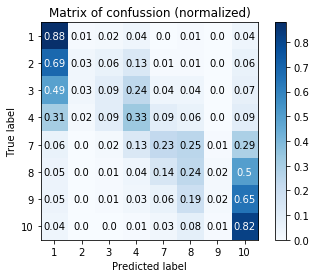

,1,2,3,4,7,8,9,10
accuracy,0.439800,0.439800,0.439800,0.439800,0.439800,0.439800,0.439800,0.439800
precision,0.509619,0.260870,0.290909,0.347549,0.335455,0.282787,0.257143,0.484920
recall,0.880924,0.031277,0.094451,0.330930,0.228435,0.242105,0.023038,0.823365
F1,0.645698,0.055857,0.142602,0.339036,0.271790,0.260870,0.042287,0.610366


In [236]:
Evaluate(lgr, X_test_tv)

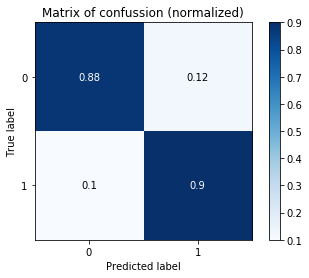

,0,1
accuracy,0.889240,0.889240
precision,0.895859,0.882839
recall,0.880880,0.897600
F1,0.888306,0.890158


In [242]:
Evaluate(lgr, X_test_tv, pn = True)

# Pretrained embeddings

In [177]:
import gensim.downloader as api

In [178]:
%%time
embeddings = api.load('glove-twitter-100')

Wall time: 4min 32s


In [183]:
def vectorize_sum(comment):
    
    embedding_dim = embeddings.vectors.shape[1]
    features = np.zeros([embedding_dim], dtype='float32')
    
    # наш preproc
    words = prep(comment).split()
    for word in words:
        if word in embeddings:
            features += embeddings[f'{word}']
    
    return features

In [180]:
%%time
X_train_wv = np.stack([vectorize_sum(text) for text in data_train])
X_test_wv = np.stack([vectorize_sum(text) for text in data_test]) 

Wall time: 6min 44s


In [181]:
X_train_wv.shape, X_test_wv.shape

((25000, 100), (25000, 100))

In [184]:
X_train_wv = shuffle(X_train_wv, random_state = 0)

In [185]:
%%time
lgr_wv = LogisticRegression(n_jobs=-1)
lgr_wv.fit(X_train_wv, y_train)

C:\Users\Timur\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Timur\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Timur\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Wall time: 55 s


C:\Users\Timur\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

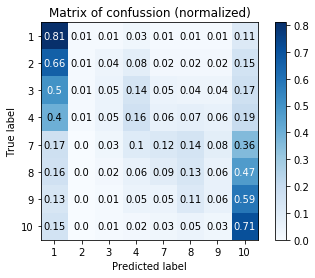

,1,2,3,4,7,8,9,10
accuracy,0.358800,0.358800,0.358800,0.358800,0.358800,0.358800,0.358800,0.358800
precision,0.412749,0.152866,0.218531,0.245614,0.243404,0.235368,0.136502,0.396266
recall,0.805854,0.010426,0.049193,0.164706,0.123971,0.131228,0.057594,0.709142
F1,0.545896,0.019520,0.080308,0.197183,0.164273,0.168506,0.081008,0.508426


In [191]:
Evaluate(lgr_wv, X_test_wv)

In [192]:
lgr2 = LogisticRegression()

In [193]:
lgr2.fit(X_train_tv, pos_neg(y_train))

C:\Users\Timur\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [215]:
mean_absolute_error(y_test, list(map(stars, lgr2.predict_proba(X_test_tv))))

1.44684

In [214]:
def stars(proba):
    if proba[0] >= proba[1]:
        s = 11 - int(round(proba[0] * 10))
    else:
        s = int(round(proba[1] * 10))
    if s == 5:
        return 4
    elif s == 6:
        return 7
    else:
        return s

In [202]:
a = lgr2.predict_proba(X_test_tv[:5])

In [203]:
list(map(stars, lgr2.predict_proba(X_test_tv)))

[8, 9, 8, 9, 10]

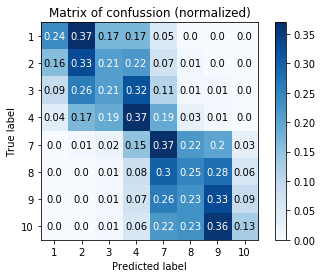

In [216]:
skplt.metrics.plot_confusion_matrix(
    y_test,
    list(map(stars, lgr2.predict_proba(X_test_tv))),
    normalize=True,
    title="Matrix of confussion (normalized)",
)
plt.show()